In [1]:
import numpy as np #for simple numpy functions
import cv2 as cv #for reading images 
from matplotlib import pyplot as plt #for showing images

### PCA

In [2]:
def getData():
    rows = 64 * 64 # number of pixel values in images
    cols = 9 * 5 # total number of training images
    dataset = np.empty(shape=(rows , cols)) 
    address = "train"
    for i in range(1, cols + 1):
        new_addr = address + "/" + str(i) + ".png"
        img = cv.cvtColor(cv.imread(new_addr), cv.COLOR_RGB2GRAY) #rgb to gray
        img = cv.resize(img ,(64 , 64))
        dataset[:, i - 1:i] = img.reshape(64*64, 1) # making dataset
    return dataset

In [3]:
data = getData()

In [4]:
def computeZeroMeanFace(data, rows): #finding zero mean face and and getting zeroed mean data
    m = data.mean(axis=1)
    m = m.reshape(rows, 1)
    zero_mean = data - m
    return m, zero_mean

In [5]:
mean , zeroed_mean = computeZeroMeanFace(data , 64 * 64)

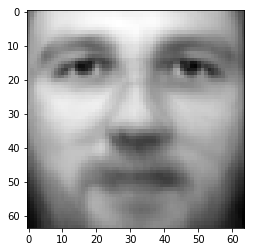

In [6]:
c = mean.reshape(64 , 64 )
plt.imshow(c , 'gray') #zero mean face

In [7]:
covariance = np.cov(zeroed_mean.T) #covariance of zero mean
covariance.shape

(45, 45)

In [8]:
c = np.dot(data.T , data) #another way to calculate mean
c /= 45
eigen_values , eigen_vectors = np.linalg.eig(c) #getting eigen values and eigen vectors
eigen_values.shape

(45,)

In [9]:
indices = eigen_values.argsort()[::-1] #sorting eigen values
eigen_values = eigen_values[indices] #getting eigen values having highest magnitude
eigen_vectors = eigen_vectors[: , indices] # getting eigen vectors corresponding to max magnitude

In [10]:
features = eigen_vectors[: , 0:20].T #selecting some eigen vectors
features.shape , zeroed_mean.shape

((20, 45), (4096, 45))

In [11]:
eigen_faces = np.dot(features, zeroed_mean.T) #getting eigen faces
norms = np.linalg.norm(eigen_faces) 
eigen_faces /= norms #making unit vectors
signature_faces = np.dot(eigen_faces, zeroed_mean) #getting signature faces
signature_faces.shape , eigen_faces.shape

((20, 45), (20, 4096))

### LDA

In [12]:
def withinClass(signature_faces): #finding within class scatter
    data = np.zeros(shape = (20 , 20))
    for i in range(5):
        mat = signature_faces[ : , i * 5 : (i+1) * 5] #taking images of each class
        mn = mat.mean(axis = 1) #taking mean of those images
        rows ,cols = mat.shape 
        mn = mn.reshape(rows , 1)
        mat = mat - mn #subtracting mean from the images
        mul = np.dot(mat , mat.T) #getting covariance 
        data += mul #adding it to final result
    return data

In [13]:
def betweenClass(signature_faces): #finding between class scatter
    data = np.zeros(shape = (20 , 20))
    mean = signature_faces.mean(axis = 1)  #mean of all signature faces
    mean = mean.reshape(20 , 1) 
    for i in range(5):
        mat = signature_faces[ : , i * 5 : (i+1) * 5] #taking images of each class
        mn = mat.mean(axis = 1) #taking mean of those images
        rows ,cols = mat.shape
        mn = mn.reshape(rows , 1)
        meandiff = mn - mean #substacting total mean from mean of each class
        mul = np.dot(meandiff , mn.T) #covariance of meandiff and each mean
        data += mul #adding to final result
    return data

In [14]:
wcs = withinClass(signature_faces)
bcs = betweenClass(signature_faces)

In [15]:
def computeJ(wcs , bcs):   #criterion function
    return (np.dot(np.linalg.inv(wcs) , bcs)) #getting criterion funtion

In [16]:
J = computeJ(wcs , bcs)

In [17]:
J.shape

(20, 20)

In [18]:
eigen_values , eigen_vectors = np.linalg.eig(J) #getting eigen values and eigen vectors of criterion function

In [19]:
indices = eigen_values.argsort()[::-1]#sorting eigen values
eigen_values = eigen_values[indices]#getting eigen values having highest magnitude
eigen_vectors = eigen_vectors[: , indices]# getting eigen vectors corresponding to max magnitude

In [20]:
features = eigen_vectors[ : , 0:15].T #selecting some eigen vectors
features.shape , zeroed_mean.shape

((15, 20), (4096, 45))

In [21]:
fisher_face = np.dot(features , signature_faces) #getting fisher faces of all images
fisher_face = fisher_face.T

### Test

In [29]:
img = cv.imread("test/z3.png") #reading test images
img = cv.cvtColor(img, cv.COLOR_RGB2GRAY) #rgb to gray
img = cv.resize(img ,(64 , 64)) 
img = img.reshape(64 * 64 , 1) #reshaping to coloumn vector
img = img - mean #subtracting zero mean face from test image
eface = np.dot(eigen_faces , img) #getting eigen face of test image
res = np.dot(features , eface) #projecting on to feature vectors

min_d = np.inf
col_number = 0
for c in fisher_face: #comparing with all fisher faces by taking distance
    v = c.reshape(res.shape)
    d = np.linalg.norm(v - res ,axis = 0)
    if d < min_d:
            min_d = d
            index = col_number
    col_number += 1
print(d)
print("face: " + str(index//9 + 1))

[225.74334769]
face: 3
